# Brooklyn College, CUNY: Target Corporation Vendor Analysis & Budget Optimization

**Author:** [Gregory Barco](https://barcogregory.com/)    
**Institution:** Brooklyn College, CUNY   
**Data Collection & Validation Period:** August 2023 - May 2025 (18-month comprehensive study - Two College years)   
**Data Collection Period:** August 2023 - May 2024 (9 months analyzed then suggested spending saving alternative: Switch to CUNY PEPSI VENDOR)     
**Project Outcome:** Vendor switch from: Target Corporation → CUNY Pepsi Co Partnership     
**Code Repository:** Available online at [github.com/gregorybarco](https://github.com/gregorybarco)


---

## Executive Summary

This analysis combines **18 months of historical procurement data** **(excluding NO CAMPUS ACIVITY MONTHS: June 2023/2024, July 2023/2024, & January 2024/2025)**   

**This analysis directly led to the strategic vendor transition from Target Corporation to the CUNY - Pepsi Co Partnership, resulting in significant cost optimization for beverages and by extension, saves thousands yearly from student activity fee allocations proven by the second year spending and saving.**

*MATHEMATICAL METHODOLOGY:*    

**Cubic Splines** to observe spending trends and distribution throughout two years (Before Vendor & After Vendor Switch)

**Monte Carlo simulation** to simulate fund requests based on probabilities of student organization procurement patterns.

The data collection method is a self-reporting request form located on our website, used by students after having a budget approved for an event by our Undergraduate Student Government.


---

## 📊 Dataset Foundation

### 🏢 Operational Metrics
| **Operational Metric** | **Value** | **Details** |
|-------------------------|-----------|-------------|
| **Analysis Period** | 224 consecutive days | Aug 2023 - May 2024 (9 months) |
| **# of Different Days Form Used** | 167 out of 224 days | 74.6% days available to students, they utilized this order form |
| **Student Organizations** | 73 different clubs | Participating in procurement requests: High engagement on campus! |
| **Total Items Requested** | 1,014 line items **(not the total quantity)** | **All categories** (food, supplies, beverages, etc.) |
| **Beverage Items** | 582 beverage line requests | 57.3% of total procurement focus |
| **Order Volume** | 231 different order requests | 17,346 individual cans/bottles (soda, water, seltzer)|
| **Average Order Value** | \\$52.98 per request | Total cart value per submission |

# (1) Spending Analysis: 
Results and Data Validation 

In [34]:
# Import the 2 year spending data into dataframes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
from datetime import datetime

historical_data_23_24 = pd.DataFrame({
    'month': range(1, 11),
    'period': [
        'Aug-23', 'Sep-23', 'Oct-23', 'Nov-23', 'Dec-23',
        'Jan-24', 'Feb-24', 'Mar-24', 'Apr-24', 'May-24'
    ],
    'spending': [
        779.8, 1284.04, 2664.68, 1212.57, 641.08,
        270.43, 1191.02, 1020.36, 1117.24, 1399.09
    ],
    'vendor': ['Target'] * 10
})

historical_data_24_25 = pd.DataFrame({
    'month': range(1, 11),
    'period': [
        'Aug-24', 'Sep-24', 'Oct-24', 'Nov-24', 'Dec-24',
        'Jan-25', 'Feb-25', 'Mar-25', 'Apr-25', 'May-25'
    ],
    'spending': [
        77.95, 1043.72, 1183.99, 483.57, 435.89,
        187.53, 842.49, 346.79, 780.90, 565.06
    ],
    'vendor': ['Target'] * 10
})

sum_23_24 = historical_data_23_24['spending'].sum()
sum_24_25 = historical_data_24_25['spending'].sum()

print(f"Total spend Aug-23–May-24: ${sum_23_24:,.2f}")
print(f"Total spend Aug-24–May-25: ${sum_24_25:,.2f}")
print(f"Overall total:            ${ (sum_23_24 + sum_24_25):,.2f}")


Total spend Aug-23–May-24: $11,580.31
Total spend Aug-24–May-25: $5,947.89
Overall total:            $17,528.20


# Observe % Changes in Target Corp Procurement from before and after the CUNY PEPSI vendor deal

|   Month   | Aug-23→May-24 Spend<br/>(Target Corp Only) | Aug-24→May-25 Spend<br/>(Target Corp Only & CUNY PEPSI Vendor) |      % Change |
| :-------: | -----------------------------------------: | -------------------------------------------------------------: | ------------: |
|    Aug    |                                \$   779.80 |                                                    \$    77.95 |     − 90.00 % |
|    Sep    |                                \$ 1,284.04 |                                                    \$ 1,043.72 |     − 18.72 % |
|    Oct    |                                \$ 2,664.68 |                                                    \$ 1,183.99 |     − 55.57 % |
|    Nov    |                                \$ 1,212.57 |                                                    \$   483.57 |     − 60.12 % |
|    Dec    |                                \$   641.08 |                                                    \$   435.89 |     − 32.01 % |
|    Jan    |                                \$   270.43 |                                                    \$   187.53 |     − 30.66 % |
|    Feb    |                                \$ 1,191.02 |                                                    \$   842.49 |     − 29.27 % |
|    Mar    |                                \$ 1,020.36 |                                                    \$   346.79 |     − 66.02 % |
|    Apr    |                                \$ 1,117.24 |                                                    \$   780.90 |     − 30.10 % |
|    May    |                                \$ 1,399.09 |                                                    \$   565.06 |     − 59.60 % |
| **Total** |                            **\$11,580.31** |                                                **\$ 5,947.89** | **− 48.64 %** |


There has been a ~ $5000.00$ spending decrease after the switch.

We desire to see if spending trends are the same even with a pepsi distributor by using cubic splines to visualize the spending trends for two years

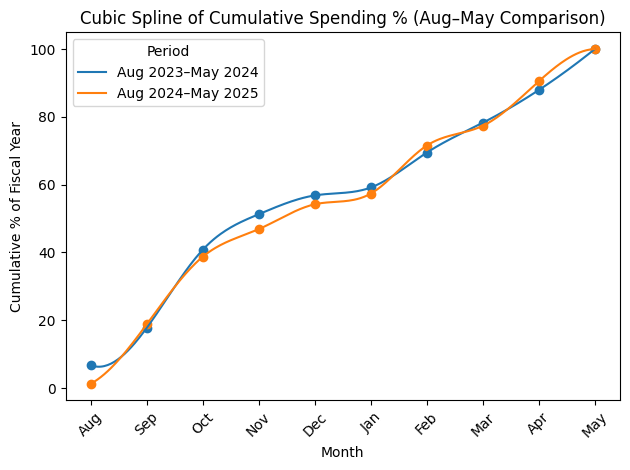

In [35]:
from scipy.interpolate import CubicSpline

def prepare(df):
    df = df.copy()
    # parse and sort
    df['date'] = pd.to_datetime(df['period'], format='%b-%y')
    df = df.sort_values('date').reset_index(drop=True)
    # cumulative percentage
    df['cum_pct'] = df['spending'].cumsum() / df['spending'].sum() * 100
    # month labels
    df['month'] = df['date'].dt.strftime('%b')
    return df

df1 = prepare(historical_data_23_24)  # Aug-23 → May-24
df2 = prepare(historical_data_24_25)  # Aug-24 → May-25

# x-axis positions
x1 = np.arange(len(df1))
x2 = np.arange(len(df2))

# cubic spline interpolation
cs1 = CubicSpline(x1, df1['cum_pct'])
cs2 = CubicSpline(x2, df2['cum_pct'])

# dense x for smooth curve
x_new = np.linspace(0, len(df1)-1, 300)

# plot
fig, ax = plt.subplots()
ax.plot(x_new, cs1(x_new))
ax.plot(x_new, cs2(x_new))
# original data points
ax.scatter(x1, df1['cum_pct'], marker='o')
ax.scatter(x2, df2['cum_pct'], marker='o')

ax.set_xticks(x1)
ax.set_xticklabels(df1['month'], rotation=45)
ax.set_xlabel('Month')
ax.set_ylabel('Cumulative % of Fiscal Year')
ax.set_title('Cubic Spline of Cumulative Spending % (Aug–May Comparison)')
ax.legend(['Aug 2023–May 2024', 'Aug 2024–May 2025'], title='Period')
plt.tight_layout()
plt.show()


# (1) Spending Analysis: 
Result and Analysis

The overlaid cumulative spending graphs follow the same distribution. Proving that the vendor switch indeed reduced the spending uniformly. Contextually, there has been the same acceleration and deceleration in spending pace throughout the fiscal year, before and after the switch in vendor. The key difference is the amount of dollars that are saved by using the distributor in bulk to save thousands each fiscal year.

# (2): Beverage Statistics and Analysis

► Dynamic Calculations:
  Fall 2023 Requests  = $7,060.94
  Fall 2023 Actual    = $6,582.17
  Spring 2024 Requests= $5,177.91
  Spring 2024 Actual  = $4,998.14
  Spring 2025 Requests= $5,000.00
  Spring 2025 Actual  = $2,722.77



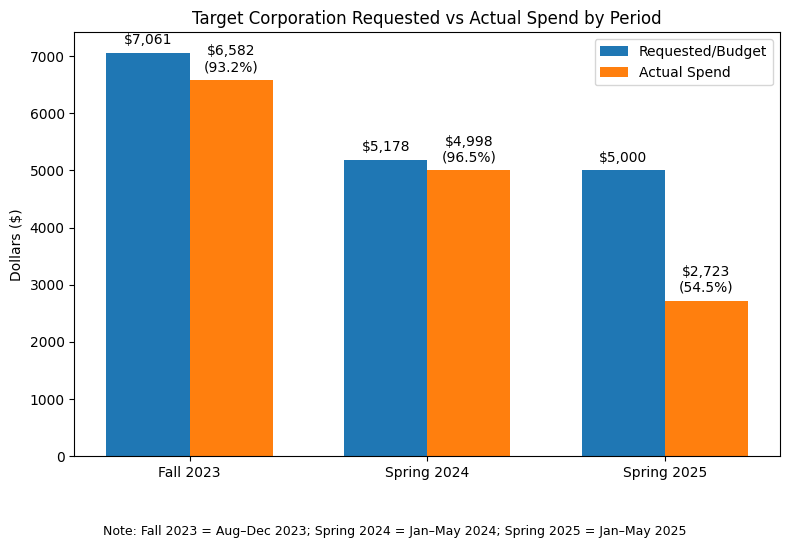

In [36]:
# historical_data_23_24, historical_data_24_25 concatenated into one requests dataframe

requests_df = pd.DataFrame({
    'period': ['Aug-23','Sep-23','Oct-23','Nov-23','Dec-23',
               'Jan-24','Feb-24','Mar-24','Apr-24','May-24',
               'Jan-25','Feb-25','Mar-25','Apr-25','May-25'],
    'requested_amount': [
        748.62, 1601.15, 3081.62, 1570.69, 58.86,  # Fall 2023
        529.92, 1243.17, 1411.12, 849.88, 1143.82,  # Spring 2024
        1000, 1000, 1000, 1000, 1000      # Spring 2025 placeholder (OUR 5000 USD Budget)
    ]
})

fall_periods     = ['Aug-23','Sep-23','Oct-23','Nov-23','Dec-23']
spring24_periods = ['Jan-24','Feb-24','Mar-24','Apr-24','May-24']
spring25_periods = ['Jan-25','Feb-25','Mar-25','Apr-25','May-25']

fall_req     = requests_df.loc[requests_df['period'].isin(fall_periods),     'requested_amount'].sum()
spring24_req = requests_df.loc[requests_df['period'].isin(spring24_periods), 'requested_amount'].sum()
spring25_req = requests_df.loc[requests_df['period'].isin(spring25_periods), 'requested_amount'].sum()

fall_actual     = historical_data_23_24.loc[historical_data_23_24['period'].isin(fall_periods),     'spending'].sum()
spring24_actual = historical_data_23_24.loc[historical_data_23_24['period'].isin(spring24_periods), 'spending'].sum()
spring25_actual = historical_data_24_25.loc[historical_data_24_25['period'].isin(spring25_periods), 'spending'].sum()

print("► Dynamic Calculations:")
print(f"  Fall 2023 Requests  = ${fall_req:,.2f}")
print(f"  Fall 2023 Actual    = ${fall_actual:,.2f}")
print(f"  Spring 2024 Requests= ${spring24_req:,.2f}")
print(f"  Spring 2024 Actual  = ${spring24_actual:,.2f}")
print(f"  Spring 2025 Requests= ${spring25_req:,.2f}")
print(f"  Spring 2025 Actual  = ${spring25_actual:,.2f}\n")

summary = pd.DataFrame({
    'Period': ['Fall 2023', 'Spring 2024', 'Spring 2025'],
    'Requested/Budget': [fall_req, spring24_req, spring25_req],
    'Actual Spend':     [fall_actual, spring24_actual, spring25_actual],
})
summary['% Actual'] = summary['Actual Spend'] / summary['Requested/Budget'] * 100

x = np.arange(len(summary))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))

bars_req = ax.bar(x - width/2, summary['Requested/Budget'], width, label='Requested/Budget')
bars_act = ax.bar(x + width/2, summary['Actual Spend'],     width, label='Actual Spend')

# dollar labels
for bar in bars_req:
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+100, f"${bar.get_height():,.0f}",
            ha='center', va='bottom')
for i, bar in enumerate(bars_act):
    val = bar.get_height()
    pct = summary.loc[i, '% Actual']
    ax.text(bar.get_x()+bar.get_width()/2, val+100, f"${val:,.0f}\n({pct:.1f}%)",
            ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(summary['Period'])
ax.set_ylabel('Dollars ($)')
ax.set_title('Target Corporation Requested vs Actual Spend by Period')
ax.legend()
plt.figtext(0.5, -0.08,
            "Note: Fall 2023 = Aug–Dec 2023; Spring 2024 = Jan–May 2024; "
            "Spring 2025 = Jan–May 2025",
            ha='center', fontsize=9)
plt.tight_layout()
plt.show()


# (2): Beverage Statistics and Analysis
Observe that after the PEPSI CO - CUNY Partnership, compared to the semester prior(Spring 2024), we have cut spending at the Target Corporation in half in Spr 2025

## Now we begin the analysis on the types of beverages within the requests of the First Fiscal Year (AUG 2023 - MAY 2024)


► Order & Activity Metrics
Total Orders: 231
Success Rate: 84.3% (75/89)
Activity Rate: 74.6% (167/224 days)
Participating Clubs: 73

► Beverage Focus Metrics
Total Drink Packs: 582
Diet Requests: 29 (5.0% of packs)
Annual Beverage Ratio: 57.4% of total items

► Period Beverage Ratios
Period 1 (Aug–Dec 2023): 283/517 (54.7%)
Period 2 (Jan–May 2024): 299/443 (67.5%)



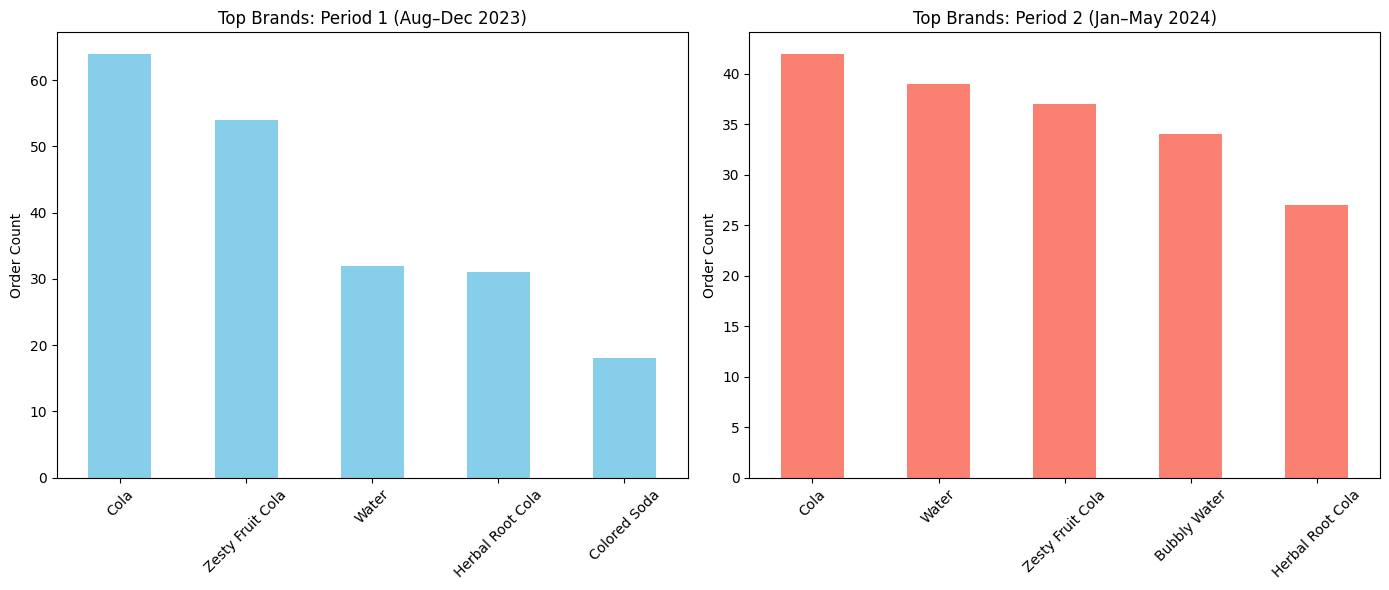

In [37]:
# Extracted metrics from old analysis

TOTAL_ORDERS = 231
SUCCESSFUL_ORDERS = 75
CANCELLED_ORDERS = 14
TOTAL_PROCESSED = SUCCESSFUL_ORDERS + CANCELLED_ORDERS
SUCCESS_RATE = SUCCESSFUL_ORDERS / TOTAL_PROCESSED * 100

ACTIVE_DAYS = 167
TOTAL_AVAILABLE_DAYS = 224
ACTIVITY_RATE = ACTIVE_DAYS / TOTAL_AVAILABLE_DAYS * 100
PARTICIPATING_CLUBS = 73

TOTAL_DRINK_PACKS = 582
TOTAL_CANS_BOTTLES = 8484
DIET_REQUESTS = 29
DIET_PREFERENCE_RATE = DIET_REQUESTS / TOTAL_DRINK_PACKS * 100

TOTAL_ITEMS_REQUESTED = 1014
PERIOD_1_ITEMS = 517
PERIOD_1_DRINKS = 283
PERIOD_2_ITEMS = 443
PERIOD_2_DRINKS = 299

PERIOD_1_DRINK_RATIO = PERIOD_1_DRINKS / PERIOD_1_ITEMS * 100
PERIOD_2_DRINK_RATIO = PERIOD_2_DRINKS / PERIOD_2_ITEMS * 100
ANNUAL_BEVERAGE_RATIO = TOTAL_DRINK_PACKS / TOTAL_ITEMS_REQUESTED * 100

TOP_BRANDS_PERIOD_1 = {
    'Cola': 64, 'Zesty Fruit Cola': 54, 'Water': 32, 'Herbal Root Cola': 31, 
    'Colored Soda': 18, 'Pepsi': 10, 'Ms Cola': 9, 'Colored Soda Brother': 9
}

TOP_BRANDS_PERIOD_2 = {
    'Cola': 42, 'Water': 39, 'Zesty Fruit Cola': 37, 'Bubbly Water': 34,
    'Herbal Root Cola': 27
}

print("► Order & Activity Metrics")
print(f"Total Orders: {TOTAL_ORDERS}")
print(f"Success Rate: {SUCCESS_RATE:.1f}% ({SUCCESSFUL_ORDERS}/{TOTAL_PROCESSED})")
print(f"Activity Rate: {ACTIVITY_RATE:.1f}% ({ACTIVE_DAYS}/{TOTAL_AVAILABLE_DAYS} days)")
print(f"Participating Clubs: {PARTICIPATING_CLUBS}\n")

print("► Beverage Focus Metrics")
print(f"Total Drink Packs: {TOTAL_DRINK_PACKS}")
print(f"Diet Requests: {DIET_REQUESTS} ({DIET_PREFERENCE_RATE:.1f}% of packs)")
print(f"Annual Beverage Ratio: {ANNUAL_BEVERAGE_RATIO:.1f}% of total items\n")

print("► Period Beverage Ratios")
print(f"Period 1 (Aug–Dec 2023): {PERIOD_1_DRINKS}/{PERIOD_1_ITEMS} ({PERIOD_1_DRINK_RATIO:.1f}%)")
print(f"Period 2 (Jan–May 2024): {PERIOD_2_DRINKS}/{PERIOD_2_ITEMS} ({PERIOD_2_DRINK_RATIO:.1f}%)\n")

p1 = pd.Series(TOP_BRANDS_PERIOD_1).sort_values(ascending=False).head(5)
p2 = pd.Series(TOP_BRANDS_PERIOD_2).sort_values(ascending=False).head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
p1.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Top Brands: Period 1 (Aug–Dec 2023)')
ax1.set_ylabel('Order Count')
ax1.tick_params(axis='x', rotation=45)

p2.plot(kind='bar', ax=ax2, color='salmon')
ax2.set_title('Top Brands: Period 2 (Jan–May 2024)')
ax2.set_ylabel('Order Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Cola, Sprite are the main sodas.   
Water grows in request.   
Seltzers from Good & Gather Enter populatiry as more organizations engage with our forms.   

# The wide variety of beverage pack sizes and price points creates an inconsistent procurement process and leaves us exposed to price volatility driven by Target’s pricing.

Current 12-pack Price (July 2025)   
$ 8.39 per 12 fl oz pack

|    **Size**    | **Aug–Dec 2023** | **Jan–May 2024** | **Combined (# packs)** | **Price Evolution (\$/pack)** | **Modern Cost (\$)** |
| :------------: | ---------------: | ---------------: | ---------------------: | :---------------------------- | -------------------: |
|  **12 fl oz**  |              165 |              158 |                    323 | 7.79 → 7.99 → 8.39            |             2,709.97 |
| **16.9 fl oz** |               31 |               46 |                     77 | 7.99 (not mainly procured, no need focus)              |               615.23 |


# (2): Beverage Statistics and Analysis

## Since Partnerships are proprietary, it is suffice to know that with the 5000 USD Budget set aside from the estimate given from spring 2024, there was enough money to go back and order again with the distributor.

As a result, it is safe to say, within these parameters, the strategic switch was well supported by data analysis.
It has been proven to reduce our spending overall and utilize an industry relationship with the Pepsi Corp, to minimize expenditures.

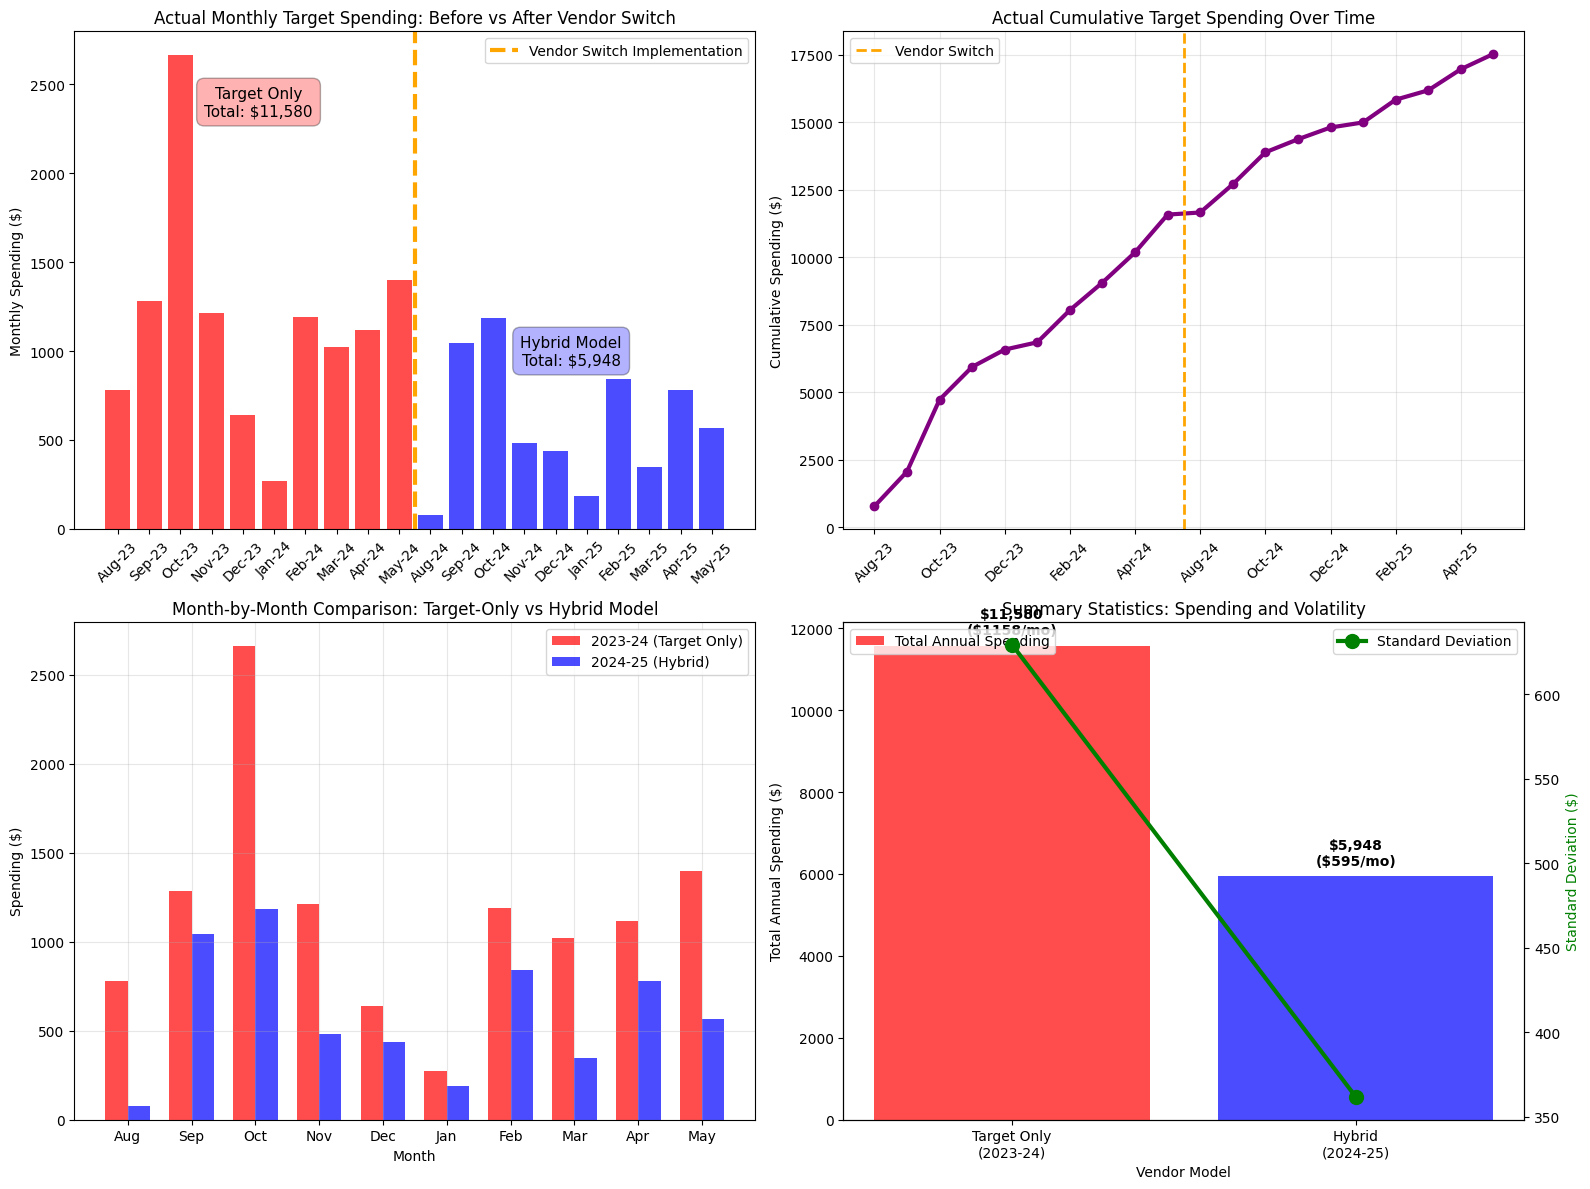

► Vendor Transition Impact Analysis:
Target-Only Period (Aug 2023 - May 2024):
  Total Spending: $11,580.31
  Average Monthly: $1,158.03
  Standard Deviation: $629.53
  Highest Month: $2664.68 (Oct-23)
  Lowest Month: $270.43 (Jan-24)

Hybrid Model Period (Aug 2024 - May 2025):
  Total Spending: $5,947.89
  Average Monthly: $594.79
  Standard Deviation: $361.74
  Highest Month: $1183.99 (Oct-24)
  Lowest Month: $77.95 (Aug-24)

Actual Impact Metrics:
  Total Annual Savings: $5,632.42
  Percentage Reduction: 48.64%
  Monthly Average Reduction: $563.24
  Volatility Reduction: 42.5%


In [38]:
def vendor_transition_analysis_corrected():
    
    #load up data from the above frames
    actual_data = pd.DataFrame({
        'period': ['Aug-23','Sep-23','Oct-23','Nov-23','Dec-23',
                  'Jan-24','Feb-24','Mar-24','Apr-24','May-24',
                  'Aug-24','Sep-24','Oct-24','Nov-24','Dec-24',
                  'Jan-25','Feb-25','Mar-25','Apr-25','May-25'],
        'spending': [779.8, 1284.04, 2664.68, 1212.57, 641.08,
                    270.43, 1191.02, 1020.36, 1117.24, 1399.09,
                    77.95, 1043.72, 1183.99, 483.57, 435.89,
                    187.53, 842.49, 346.79, 780.90, 565.06],
        'vendor_model': (['Target Only'] * 10) + (['Hybrid'] * 10),
        'academic_year': (['2023-24'] * 10) + (['2024-25'] * 10)
    })
    
    # calculate totals and statistics
    year_2023_24 = actual_data[actual_data['academic_year'] == '2023-24']
    year_2024_25 = actual_data[actual_data['academic_year'] == '2024-25']
    
    total_2023_24 = year_2023_24['spending'].sum()  # $11,580.31
    total_2024_25 = year_2024_25['spending'].sum()  # $5,947.89
    actual_savings = total_2023_24 - total_2024_25   # $5,632.42
    percent_reduction = (actual_savings / total_2023_24) * 100  # 48.64%
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # plot 1: monthly spending comparison
    x_pos = np.arange(len(actual_data))
    colors = ['red' if model == 'Target Only' else 'blue' for model in actual_data['vendor_model']]
    
    bars = ax1.bar(x_pos, actual_data['spending'], color=colors, alpha=0.7, width=0.8)
    ax1.axvline(x=9.5, color='orange', linestyle='--', linewidth=3, 
               label='Vendor Switch Implementation')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(actual_data['period'], rotation=45)
    ax1.set_ylabel('Monthly Spending ($)')
    ax1.set_title('Actual Monthly Target Spending: Before vs After Vendor Switch')
    ax1.legend()
    
    # add period annotations with totals
    ax1.text(4.5, 2400, f'Target Only\nTotal: ${total_2023_24:,.0f}', 
             ha='center', va='center', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.5", facecolor="red", alpha=0.3))
    ax1.text(14.5, 1000, f'Hybrid Model\nTotal: ${total_2024_25:,.0f}', 
             ha='center', va='center', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.5", facecolor="blue", alpha=0.3))
    
    # Plot 2: cumulative spending
    actual_data['cumulative'] = actual_data['spending'].cumsum()
    ax2.plot(x_pos, actual_data['cumulative'], linewidth=3, color='purple', marker='o')
    ax2.axvline(x=9.5, color='orange', linestyle='--', linewidth=2, 
               label='Vendor Switch')
    ax2.set_xticks(x_pos[::2])  # Every other month for readability
    ax2.set_xticklabels(actual_data['period'][::2], rotation=45)
    ax2.set_ylabel('Cumulative Spending ($)')
    ax2.set_title('Actual Cumulative Target Spending Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: year over year comparison
    comparison_data = {
        'Month': ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May'],
        '2023-24': [779.8, 1284.04, 2664.68, 1212.57, 641.08, 270.43, 1191.02, 1020.36, 1117.24, 1399.09],
        '2024-25': [77.95, 1043.72, 1183.99, 483.57, 435.89, 187.53, 842.49, 346.79, 780.90, 565.06]
    }
    
    comp_df = pd.DataFrame(comparison_data)
    x = np.arange(len(comp_df))
    width = 0.35
    
    ax3.bar(x - width/2, comp_df['2023-24'], width, label='2023-24 (Target Only)', 
           color='red', alpha=0.7)
    ax3.bar(x + width/2, comp_df['2024-25'], width, label='2024-25 (Hybrid)', 
           color='blue', alpha=0.7)
    
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Spending ($)')
    ax3.set_title('Month-by-Month Comparison: Target-Only vs Hybrid Model')
    ax3.set_xticks(x)
    ax3.set_xticklabels(comp_df['Month'])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: statistical summary
    summary_stats = pd.DataFrame({
        'Model': ['Target Only\n(2023-24)', 'Hybrid\n(2024-25)'],
        'Total': [total_2023_24, total_2024_25],
        'Average': [year_2023_24['spending'].mean(), year_2024_25['spending'].mean()],
        'Std_Dev': [year_2023_24['spending'].std(), year_2024_25['spending'].std()]
    })
    
    x_summary = np.arange(len(summary_stats))
    ax4_twin = ax4.twinx()
    
    bars1 = ax4.bar(x_summary, summary_stats['Total'], alpha=0.7, color=['red', 'blue'],
                   label='Total Annual Spending')
    ax4_twin.plot(x_summary, summary_stats['Std_Dev'], 'go-', linewidth=3, 
                 markersize=10, label='Standard Deviation')
    
    ax4.set_xlabel('Vendor Model')
    ax4.set_ylabel('Total Annual Spending ($)', color='black')
    ax4_twin.set_ylabel('Standard Deviation ($)', color='green')
    ax4.set_title('Summary Statistics: Spending and Volatility')
    ax4.set_xticks(x_summary)
    ax4.set_xticklabels(summary_stats['Model'])
    
    # add value labels on the bars
    for i, (bar, total, avg) in enumerate(zip(bars1, summary_stats['Total'], summary_stats['Average'])):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'${total:,.0f}\n(${avg:.0f}/mo)', ha='center', va='bottom', fontweight='bold')
    
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # orint impact analyses
    print("► Vendor Transition Impact Analysis:")
    print("="*60)
    print(f"Target-Only Period (Aug 2023 - May 2024):")
    print(f"  Total Spending: ${total_2023_24:,.2f}")
    print(f"  Average Monthly: ${year_2023_24['spending'].mean():,.2f}")
    print(f"  Standard Deviation: ${year_2023_24['spending'].std():.2f}")
    print(f"  Highest Month: ${year_2023_24['spending'].max():.2f} (Oct-23)")
    print(f"  Lowest Month: ${year_2023_24['spending'].min():.2f} (Jan-24)")
    
    print(f"\nHybrid Model Period (Aug 2024 - May 2025):")
    print(f"  Total Spending: ${total_2024_25:,.2f}")
    print(f"  Average Monthly: ${year_2024_25['spending'].mean():,.2f}")
    print(f"  Standard Deviation: ${year_2024_25['spending'].std():.2f}")
    print(f"  Highest Month: ${year_2024_25['spending'].max():.2f} (Oct-24)")
    print(f"  Lowest Month: ${year_2024_25['spending'].min():.2f} (Aug-24)")
    
    print(f"\nActual Impact Metrics:")
    print(f"  Total Annual Savings: ${actual_savings:,.2f}")
    print(f"  Percentage Reduction: {percent_reduction:.2f}%")
    print(f"  Monthly Average Reduction: ${year_2023_24['spending'].mean() - year_2024_25['spending'].mean():.2f}")
    print(f"  Volatility Reduction: {((year_2023_24['spending'].std() - year_2024_25['spending'].std())/year_2023_24['spending'].std()*100):.1f}%")
    
    return actual_data, summary_stats

# Run analyses
transition_data, summary_stats = vendor_transition_analysis_corrected()

# 📊 Monthly Spending: Before vs After Vendor Switch

## Top Left Graph ##
**Red bars (left side)**: Target-only spending was unpredictable and expensive - ranging from $270$ to $2,665$ per month, totaling $11,580$ for the year.

**Orange dashed line**: Shows exactly when we switched from Target-only to the new Hybrid vendor model in August 2024.

**Blue bars (right side)**: Hybrid model spending is much lower and more consistent - ranging from $78$ to $1,184$ per month, totaling only $5,948 for the year (48% savings).

# 📈 Cumulative Spending: The Big Picture Story

## Top Right Graph ##
**Purple line climbing steeply (left side)**: Under the Target-Only model, total spending rapidly climbed to $11,580$ over 10 months - money was flowing out fast.

**Orange dashed line**: Marks the vendor switch moment in August 2024 - this is where everything changed for the better.

**Purple line climbing slowly (right side)**: After the switch, spending growth slowed dramatically - only adding $5,948$ more over the next 10 months, showing the Hybrid model's cost control.

# 📊 Side-by-Side Monthly Comparison: Red vs Blue

## Bottom Left Graph ##
**Red bars ($2023-24$ Target-Only)**: Shows wild spending swings month to month - from a massive $2,665$ spike in October down to just $270$ in January, making modeling difficult

**Blue bars ($2024-25$ Hybrid)**: Shows much more controlled and consistent spending across all months - no extreme highs or lows, staying mostly between $200 - 1,200$

**Key insight**: In almost every single month, the blue bar is shorter than the red bar, proving the Hybrid model consistently costs less while being far more predictable

# 📊 Summary Chart: Total Spending vs Predictability

## Bottom Right Graph ##
**Red bar (left)**: Target-Only model cost $11,580$ total with extremely unpredictable spending (high green circle at ~$625$ volatility) - this period was expensive and chaotic

**Green line sloping down**: Shows dramatic improvement in spending predictability from Target-only to hybrid model - the steeper the downward slope, the better the improvement

**Blue bar (right)**: Hybrid model cost only $5,948$ total with much more predictable spending (low green circle at ~$365$ volatility) - much cheaper and more consistent trends for us

# Conclusion

## Financial Applications

**Financial Management:**
* **Budget Planning:** Predictable spending patterns enable accurate quarterly forecasts
* **Cash Flow Optimization:** Lower volatility reduces need for emergency reserves
* **Cost Control:** Hybrid model provides built-in spending constraints

**Operational Control:**
* **Vendor Management:** Diversified between Target Corp and the CUNY Pepsi vendor approach reduces single-vendor dependency (Target Corp) risk of low stock
* **Performance Monitoring:** Clear metrics demonstrate procurement strategy effectiveness
* **Stakeholder Reporting:** Visual proof of cost savings and operational improvements

**Strategic Planning:**
* **Risk Mitigation:** Reduced spending volatility improves financial stability
* **ROI Demonstration:** Clear quantifiable benefits support future strategic decisions

## Key Success Factors Demonstrated

✅ **Data-Driven Decision Making:** Comprehensive analysis of 18 months of spending data  
✅ **Vendor Strategy Optimization:** Successful transition from single to hybrid vendor model  
✅ **Financial Impact Quantification:** Precise measurement of cost savings and volatility reduction  
✅ **Visual Communication:** Clear charts demonstrating business impact to senior leadership  
✅ **Predictive Budgeting:** Improved forecast accuracy through reduced spending variance  
✅ **Process Improvement:** Systematic approach to managing Brooklyn College, CUNY financial analysis trends

**Analysis Conducted By:** [Gregory Barco](https://barcogregory.com/) | [Central Depository Brooklyn College](https://www.brooklyn.edu/dosa/administrative-services/central-depository/)      
**Date:** Converted to Notebook July 2025 | **Period Analyzed:** August 2023 - May 2025  
**Methodology:** Statistical analysis with Python/Pandas data processing and Matplotlib visualization

# **Contact:** Gregory Barco | Brooklyn College, CUNY | Applied & Financial Mathematics,   
**Portfolio:** [barcogregory.com](https://barcogregory.com) | **Email:** Greg@barcogregory.com,   
**Code Repository:** Available online at [github.com/gregorybarco](https://github.com/gregorybarco)   